# Do Friends Like the Same Movies?

Data Used: Employee_Movie_Choices.txt, Employee_Relationships.txt

This project's focus is to visualize a network of employees at a hypothetical company.  The goal is to find if there is a correlation between shared favorite movies and the strength of the relationship between employees that share a favorite movie.  

A total of eight employees, they were asked to choose 3 movies that they consider to be their favorite.  These choices are stored in the file Employee_Movie_Choices.txt.

A second file, Employee_Relationships.txt, has data on the relationships between different coworkers.

The relationship score has value of -100 (Enemies) to +100 (Best Friends). A value of zero means the two employees haven't interacted or are indifferent.

Both files are tab delimited.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
import warnings
warnings.filterwarnings('ignore')

# This is the set of employees
employees = set(['Pablo',
                 'Lee',
                 'Georgia',
                 'Vincent',
                 'Andy',
                 'Frida',
                 'Joan',
                 'Claude'])

# This is the set of movies
movies = set(['The Shawshank Redemption',
              'Forrest Gump',
              'The Matrix',
              'Anaconda',
              'The Social Network',
              'The Godfather',
              'Monty Python and the Holy Grail',
              'Snakes on a Plane',
              'Kung Fu Panda',
              'The Dark Knight',
              'Mean Girls'])

# Build graph
def plot_graph(G, weight_name=None):
    '''
    G: a networkx G
    weight_name: name of the attribute for plotting edge weights (if G is weighted)
    '''
    %matplotlib notebook
    import matplotlib.pyplot as plt
    
    plt.figure()
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = None
    
    if weight_name:
        weights = [int(G[u][v][weight_name]) for u,v in edges]
        labels = nx.get_edge_attributes(G,weight_name)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        nx.draw_networkx(G, pos, edges=edges, width=weights)
    else:
        nx.draw_networkx(G, pos, edges=edges)

### Step 1: Load Bipartite Graph of Movie Choices

<IPython.core.display.Javascript object>


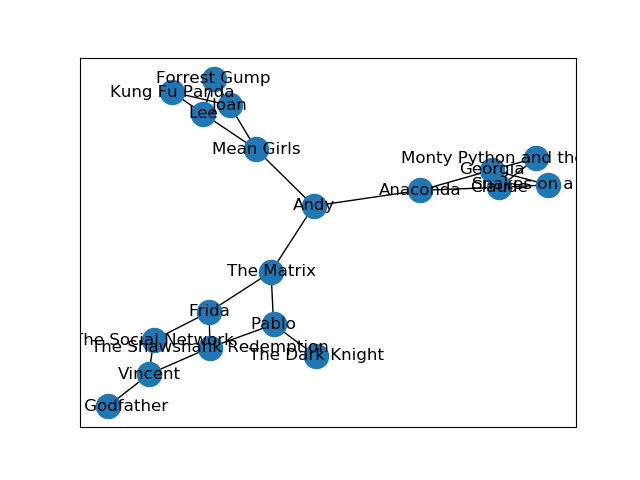

In [2]:
def Movie_G():
    df = pd.read_csv('Employee_Movie_Choices.txt', delimiter='\t')
    L = df['#Employee']
    R = df['Movie']
    B = nx.Graph()
    B.add_nodes_from(set(L), bipartite=0)
    B.add_nodes_from(list(R), bipartite=1)
    c = 0
    edges = []
    while c < len(df):
        edges.append((L[c], R[c]))
        c+=1
    B.add_edges_from(edges)
    return B
plot_graph(Movie_G(), weight_name=None)

### Step 2: Differentiate Nodes by Employee or Movie

In [3]:
def Empl_or_Movie():
    B = Movie_G()
    for node in B.nodes():
        if node in employees:
            B.add_node(node, type="employee")
        else:
            B.add_node(node, type="movie")
    return B
Empl_or_Movie().nodes(data=True)

NodeDataView({'Andy': {'bipartite': 0, 'type': 'employee'}, 'Frida': {'bipartite': 0, 'type': 'employee'}, 'Joan': {'bipartite': 0, 'type': 'employee'}, 'Pablo': {'bipartite': 0, 'type': 'employee'}, 'Claude': {'bipartite': 0, 'type': 'employee'}, 'Vincent': {'bipartite': 0, 'type': 'employee'}, 'Georgia': {'bipartite': 0, 'type': 'employee'}, 'Lee': {'bipartite': 0, 'type': 'employee'}, 'Anaconda': {'bipartite': 1, 'type': 'movie'}, 'Mean Girls': {'bipartite': 1, 'type': 'movie'}, 'The Matrix': {'bipartite': 1, 'type': 'movie'}, 'Monty Python and the Holy Grail': {'bipartite': 1, 'type': 'movie'}, 'Snakes on a Plane': {'bipartite': 1, 'type': 'movie'}, 'The Shawshank Redemption': {'bipartite': 1, 'type': 'movie'}, 'The Social Network': {'bipartite': 1, 'type': 'movie'}, 'Forrest Gump': {'bipartite': 1, 'type': 'movie'}, 'Kung Fu Panda': {'bipartite': 1, 'type': 'movie'}, 'The Dark Knight': {'bipartite': 1, 'type': 'movie'}, 'The Godfather': {'bipartite': 1, 'type': 'movie'}})

### Step 3: Find a weighted projection of the data from Step 2 which tells us how many movies different pairs of employees have in common

<IPython.core.display.Javascript object>


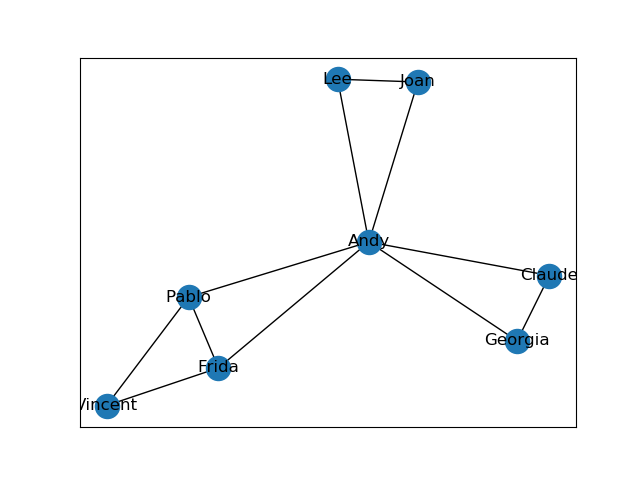

In [4]:
def Weighted_P():
    B = Empl_or_Movie()
    weighted_projection = bipartite.weighted_projected_graph(B, employees)
    return weighted_projection
plot_graph(Weighted_P(), weight_name=None)

We can see left to right that the connections more to the right of the graph have more movies in common

### Step 4:  Determine Correlation

Finds the Pearson correlation between employee relationship scores and the number of movies they have in common. If two employees have no movies in common it is treated as a 0, not a missing value, and included in the correlation calculation.  Output is a table of each node's relationship and common favorite movie counts.

In [5]:
def corr_table():
    Rel = nx.read_edgelist('Employee_Relationships.txt', data=[('relationship_score', int)])
    Rel_df = pd.DataFrame(Rel.edges(data=True), columns=['From', 'To', 'relationship_score']) # cleaning up data input
    G = Weighted_P() # import projected graph
    G_df = pd.DataFrame(G.edges(data=True), columns=['From', 'To', 'movies_score']) # convert to dataframe
    G_copy_df = G_df.copy()
    G_copy_df.rename(columns={"From":"From_", "To":"From"}, inplace=True)
    G_copy_df.rename(columns={"From_":"To"}, inplace=True)
    G_final_df = pd.concat([G_df, G_copy_df]) # combine to go both ways (i.e. Andy -> Claude, Claude -> Andy)
    final_df = pd.merge(G_final_df, Rel_df, on = ['From', 'To'], how='right') 
    final_df['movies_score'] = final_df['movies_score'].map(lambda x: x['weight'] if type(x)==dict else None) # pull values out of dictionary
    final_df['relationship_score'] = final_df['relationship_score'].map(lambda x: x['relationship_score'])
    final_df['movies_score'].fillna(value=0, inplace=True)
    print(final_df)
    return final_df['movies_score'].corr(final_df['relationship_score'])
print('\nThe relationship between movie score and relationship score has a positive correlation of {}'.format(round(corr_table(),3)))

       From       To  movies_score  relationship_score
0      Andy    Frida           1.0                  20
1      Andy     Joan           1.0                  30
2      Andy    Pablo           1.0                 -10
3      Andy   Claude           1.0                   0
4      Andy  Georgia           1.0                 -10
5      Andy      Lee           1.0                 -10
6     Frida    Pablo           2.0                  50
7     Frida  Vincent           2.0                  60
8      Joan      Lee           3.0                  70
9     Pablo  Vincent           1.0                 -20
10   Claude  Georgia           3.0                  90
11     Andy  Vincent           0.0                  20
12   Claude    Frida           0.0                   0
13   Claude     Joan           0.0                   0
14   Claude      Lee           0.0                   0
15   Claude    Pablo           0.0                  10
16   Claude  Vincent           0.0                   0
17    Frid